### <b>Install the required libraries</b>

In [1]:
# Install the transformers library (Allows importing models from Hugging Face)
!pip install transformers
!pip install datasets 

### <b>Import necessary libraries</b>

In [2]:
import copy 
import json
import logging 
import os 

import warnings
warnings.filterwarnings("ignore")
import logging
logging.basicConfig(level=logging.ERROR)

import numpy as np
import pandas as pd
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch

In [3]:
# Check if CUDA is available
print("CUDA Available:", torch.cuda.is_available())

# If CUDA is available, print the current GPU details
if torch.cuda.is_available():
    print("Current GPU Index:", torch.cuda.current_device())
    print("Current GPU Name:", torch.cuda.get_device_name(torch.cuda.current_device()))
    print("GPU Memory Allocated:", torch.cuda.memory_allocated())
    print("GPU Memory Cached:", torch.cuda.memory_cached())

CUDA Available: True
Current GPU Index: 0
Current GPU Name: GeForce RTX 2080 Ti
GPU Memory Allocated: 0
GPU Memory Cached: 0


### <b>Load the model from Hugging Face's model hub</b>

In [4]:
import transformers
from transformers import AutoConfig, AutoModel, AutoModelForSequenceClassification, AutoTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup

In [5]:
MODEL_CLASSES = ["klue/roberta-base", "klue/roberta-small", "klue/roberta-large"]

In [6]:
from transformers import AutoModel, AutoTokenizer, BigBirdConfig

model_path = MODEL_CLASSES[0]
model = AutoModel.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

text = "한국어 RoBERTa 모델을 공개합니다!"
encoded_input = tokenizer(text, return_tensors='pt', truncation=True)
output = model(**encoded_input)

Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# Print the values of the final hidden state
print(output[0])

# Print the shape of the final hidden state
print(output[0].shape)

tensor([[[ 0.1110, -0.5521, -0.1322,  ..., -0.1391, -0.0510, -0.0055],
         [ 0.1413,  0.4770,  0.5635,  ..., -0.7846,  0.2246, -0.3912],
         [ 0.2544,  0.5302,  1.2237,  ..., -0.9378,  0.0804, -0.7586],
         ...,
         [-0.6702,  0.3013,  0.2721,  ..., -0.3141,  0.2496, -0.5966],
         [-0.2941,  0.1332, -0.1701,  ..., -0.3679,  0.6020, -0.3439],
         [ 0.1102, -0.5519, -0.1323,  ..., -0.1397, -0.0506, -0.0053]]],
       grad_fn=<NativeLayerNormBackward0>)
torch.Size([1, 13, 768])


### <b>Set hyperparameters for the experiment</b>

In [8]:
from types import SimpleNamespace

# Create a configuration object to store hyperparameters and other settings
config = SimpleNamespace()

config.task = "roberta_profanity"
config.dataset = "KoMultiText"

config.cache_dir = "roberta_profanity_cache" # Temporary directory for current task assets like vocabulary
config.output_dir = "roberta_profanity_output" # Directory where final models and results will be saved

config.use_tpu = False
config.model_name_or_path = model_path 
config.data_dir = "./" # The input data dir 

config.train_file = "train_dataset.csv" 
config.predict_file = "test_dataset.csv" 

config.max_seq_length = 512 # Maximum sequence length
config.train_batch_size = 8 # Batch size for training
config.eval_batch_size = 4 # Batch size for evaluation

config.learning_rate = 3e-6 # The initial learning rate for Adam
config.num_train_epochs = 20 # Total number of training epochs to perform

config.gradient_accumulation_steps = 4 # Number of updates steps to accumulate before performing a backward/update pass.
config.threads = 4
config.seed = 42 

config.device_num = 0 # Device number (changable for multi-GPU setups)

config.do_train = True 
config.do_eval_during_train = True
config.do_eval = True 

config.do_lower_case = False
config.weight_decay = 0.0 # Weight decay if we apply some.
config.adam_epsilon = 1e-8 # Epsilon for Adam optimizer.
config.max_grad_norm = 1.0 # Max gradient norm.
config.warmup_proportion = 0.0 # Warmup proportion for linear warmup

### <b>Preprocessing the training dataset</b>
* Instead of tokenizing the training text every time, we preprocess and <b>save all tokenized results before starting the model training</b>.
    * This approach significantly speeds up the process.

In [9]:
tokenizer = AutoTokenizer.from_pretrained(config.model_name_or_path, do_lower_case=False, cache_dir=config.cache_dir)

In [10]:
def train_split(config, texts, labels, is_train):
    x_train, y_train, x_label, y_label = train_test_split(
        texts, labels, test_size=0.2, random_state=config.seed, stratify=None
    )
    if is_train:
        texts, labels = x_train, x_label
    else:
        texts, labels = y_train, y_label
        
    return texts, labels

def process_comment_cls(config, data_file, is_train):
    df = pd.read_csv(data_file)
    profanity = df["profanity"].astype(int).values.tolist()
    labels = profanity
    texts = df["comment"].astype(str).values.tolist()
    texts, labels = train_split(config, texts, labels, is_train)
    
    return texts, labels

In [11]:
import torch.utils.data as torch_data

def data_pretokenizing(config, tokenizer, is_train=True):
    if is_train:
        data_file = config.train_file
    else:
        data_file = config.predict_file

    data_path = config.data_dir
    if data_file is not None:
        data_path = os.path.join(data_path, data_file)
    else:
        data_path += "/"
    
    # Construct the file name for the tokenized dataset
    comps = [
        data_path,
        config.dataset,
        config.model_name_or_path.replace("/", "_"),
        config.max_seq_length,
        "train" if is_train else "dev",
        "dataset.txt",
    ]
    dataset_file = "_".join([str(comp) for comp in comps])
    print("dataset_file:", dataset_file)
    
    # Tokenize the dataset and write to the file
    with open(dataset_file, "w", encoding="utf-8") as writer_file:
        cnt = 0
        total_data = process_comment_cls(config, data_path, is_train)
        for text, label in zip(total_data[0], total_data[1]):
            feature = tokenizer(text, max_length=config.max_seq_length, padding="max_length", truncation=True, add_special_tokens=True)
            writed_data = {
                "input_ids": feature["input_ids"],
                "attention_mask": feature["attention_mask"],
                "profanity": int(label), 
            }
            writer_file.write(json.dumps(writed_data) + "\n")
            cnt += 1
        print(f"{cnt} features processed from {data_path}")

    return dataset_file

In [12]:
if config.do_train:
    train_dataset_file = data_pretokenizing(config, tokenizer=tokenizer)
predict_dataset_file = data_pretokenizing(config, tokenizer=tokenizer, is_train=False)

dataset_file: ./train_dataset.csv_KoMultiText_klue_roberta-base_512_train_dataset.txt
30688 features processed from ./train_dataset.csv
dataset_file: ./test_dataset.csv_KoMultiText_klue_roberta-base_512_dev_dataset.txt
400 features processed from ./test_dataset.csv


### <b>Initialize the data loader</b>

In [13]:
class IterableDatasetPad(torch.utils.data.IterableDataset):
    def __init__(
        self,
        dataset: torch.utils.data.IterableDataset,
        batch_size: int = 1,
        num_devices: int = 1,
        seed: int = 0,
    ):
        self.dataset = dataset
        self.batch_size = batch_size
        self.seed = seed
        self.num_examples = 0

        chunk_size = self.batch_size * num_devices
        length = len(dataset)
        self.length = length + (chunk_size - length % chunk_size)

    def __len__(self):
        return self.length

    def __iter__(self):
        self.num_examples = 0
        if (
            not hasattr(self.dataset, "set_epoch")
            and hasattr(self.dataset, "generator")
            and isinstance(self.dataset.generator, torch.Generator)
        ):
            self.dataset.generator.manual_seed(self.seed + self.epoch)

        first_batch = None
        current_batch = []
        for element in self.dataset:
            self.num_examples += 1
            current_batch.append(element)
            if len(current_batch) == self.batch_size:
                for batch in current_batch:
                    yield batch
                    if first_batch is None:
                        first_batch = batch.copy()
                current_batch = []

        while self.num_examples < self.length:
            add_num = self.batch_size - len(current_batch)
            self.num_examples += add_num
            current_batch += [first_batch] * add_num
            for batch in current_batch:
                yield batch
            current_batch = []

In [14]:
def collate_fn(features):
    
    input_ids = [sample["input_ids"] for sample in features]
    attention_mask = [sample["attention_mask"] for sample in features]
    
    profanity = [sample["profanity"] for sample in features]

    input_ids = torch.tensor(np.array(input_ids).astype(np.int64), dtype=torch.long)
    attention_mask = torch.tensor(np.array(attention_mask).astype(np.int8), dtype=torch.long)
    
    profanity = torch.tensor(np.array(profanity).astype(np.int64), dtype=torch.long)
    inputs = {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
    }
    labels =  profanity

    return inputs, labels

if config.do_train:
    train_dataset = load_dataset("text", data_files=train_dataset_file, download_mode="force_redownload")["train"]
    train_dataset = train_dataset.map(lambda x: json.loads(x["text"]), batched=False)

    train_dataloader = torch_data.DataLoader(
        train_dataset,
        sampler=torch_data.RandomSampler(train_dataset),
        drop_last=False,
        batch_size=config.train_batch_size,
        collate_fn=(collate_fn),
    )

predict_dataset = load_dataset("text", data_files=predict_dataset_file, download_mode="force_redownload")["train"]
predict_dataset = predict_dataset.map(lambda x: json.loads(x["text"]), batched=False)
predict_dataset = IterableDatasetPad(
    dataset=predict_dataset,
    batch_size=config.eval_batch_size,
    num_devices=1,
    seed=config.seed,
)

predict_dataloader = torch_data.DataLoader(
    predict_dataset,
    sampler=None,
    drop_last=False,
    batch_size=config.eval_batch_size,
    collate_fn=(collate_fn),
)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset text downloaded and prepared to /home/dasol/.cache/huggingface/datasets/text/default-0da5479ba8883639/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/30688 [00:00<?, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset text downloaded and prepared to /home/dasol/.cache/huggingface/datasets/text/default-a0742023f714bfc5/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

### <b>Define the text classification model</b>

In [15]:
from transformers import AutoModel
import torch.nn as nn

class ClsModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        data_file = os.path.join(config.data_dir, str(config.train_file))  
        model_config = AutoConfig.from_pretrained(config.model_name_or_path, num_labels=1)
        self.model = AutoModel.from_pretrained(
            config.model_name_or_path, config=model_config, cache_dir=config.cache_dir
        )
        self.classifier = nn.Linear(768, 1) 
        self.tokenizer = tokenizer

    def save_pretrained(self, save_dir):
        self.model.save_pretrained(save_dir)
        # Remove unnecessary keys from the tokenizer's init_kwargs
        for key in ["special_tokens_map_file", "tokenizer_file"]:
            self.tokenizer.init_kwargs.pop(key, None)
        self.tokenizer.save_pretrained(save_dir)

    def get_optimizer(self): 
        # Specify parameters that should not undergo weight decay during training
        no_decay = ["bias", "LayerNorm.weight"]
        # Group model parameters based on whether they should have weight decay or not
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in self.model.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": config.weight_decay,
            },
            {
                "params": [p for n, p in self.model.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": config.weight_decay,
            },
        ]
        
        optimizer = AdamW(optimizer_grouped_parameters, lr=config.learning_rate, eps=config.adam_epsilon)
        return optimizer

    def get_scheduler(self, batch_num, optimizer): 
        # If no warmup is needed, return None
        if config.warmup_proportion == 0.0:
            return None
        
        # Calculate the total number of training steps
        t_total = batch_num // config.gradient_accumulation_steps * config.num_train_epochs
        
        # Define the learning rate scheduler with a linear warmup phase
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=int(t_total * config.warmup_proportion),
            num_training_steps=t_total,
        )

        return scheduler

    def forward(self, inputs):
        hidden = self.model(**inputs) # Get the model's hidden states
        # Extract [CLS] token from the last layer
        cls_token_embeddings = hidden.last_hidden_state[:,0,:] # [batch_size, 768]
        output = self.classifier(cls_token_embeddings) # 768 → 1

        return output

    def eval_step(self, inputs, labels, outputs):
        labels = labels.cpu().detach().numpy()
        threshold = 0.5
        sigmoid_outputs = torch.sigmoid(outputs).cpu().detach().numpy()
        predictions = (sigmoid_outputs >= threshold).astype(int)  # Apply threshold and convert to integer (0 or 1)
        class_probabilities = sigmoid_outputs.tolist()

        results = {"prediction": predictions.tolist(), "label": labels.tolist(),  "prob": class_probabilities}
        
        return results

    def tensor_to_array(self, tensor):
        return tensor.detach().cpu().numpy()
    
    def tensor_to_list(self, tensor):
        return self.tensor_to_array(tensor).tolist()

In [16]:
# Set the random seed for reproducibility in both numpy and PyTorch
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

# Calculate the running average of the loss using a decay factor
def cal_running_avg_loss(loss, running_avg_loss, decay=0.99):
    if running_avg_loss == 0:
        return loss
    running_avg_loss = running_avg_loss * decay + (1 - decay) * loss
    return running_avg_loss

### <b>Define the functions for training and evaluation</b>

In [17]:
import numpy as np
import sklearn.metrics as sklearn_metrics
from sklearn.metrics import precision_recall_curve, auc, roc_curve
import matplotlib.pyplot as plt

def calculate_pr_auc(labels, prob):
    precision, recall, _ = precision_recall_curve(labels, prob)
    return auc(recall, precision)

def plot_roc_curve(labels, probs, category_name):
    fpr, tpr, _ = roc_curve(labels, probs)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure(figsize=(11, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'{category_name} (AUROC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {category_name}')
    plt.legend(loc="lower right")
    plt.show()

# for binary-classification
binary_metrics = {
    "accuracy": sklearn_metrics.accuracy_score,
    "precision": sklearn_metrics.precision_score, # TP / (TP + FP)
    "recall": sklearn_metrics.recall_score, # recall = sensitivity (민감도)
    "f1": sklearn_metrics.f1_score,
    "matthews_corrcoef": sklearn_metrics.matthews_corrcoef,
}

def eval_cls(predictions, labels, probs,  **kwargs):
    
    predictions = np.array(predictions)
    labels = np.array(labels)
    probs = np.array(probs)

    results = {
        metric: round(f(labels, predictions) * 100, 2)
        for metric, f in binary_metrics.items()
    }

    # Calculate AUROC
    fpr, tpr, _ = roc_curve(labels, probs)
    roc_auc = auc(fpr, tpr)
    results["roc_auc"] = round(roc_auc * 100, 2)

    # Plot ROC curve
    plot_roc_curve(labels, probs, "Profanity AUROC")

    return {
        "results": results,
        "best_score": results["f1"],
        "roc_auc": results["roc_auc"]
    }


In [18]:
def _run_epoch(model, loader, device=None, context=None, **kwargs):
    
    config = kwargs["config"]
    is_train = kwargs["is_train"]

    avg_loss = 0
    results = []
    batch_num = len(loader)
    
    # Set the model to train or eval mode based on 'is_train'
    if is_train:
        model.train()
        if config.use_tpu:
            optimizer = context.getattr_or(
                "optimizer",
                lambda: model.get_optimizer(),
            )
            scheduler = context.getattr_or(
                "scheduler",
                lambda: model.get_scheduler(batch_num, optimizer),
            )
        else:
            optimizer = kwargs["optimizer"]
            scheduler = kwargs["scheduler"]
    else:
        model.eval()
    
    # ProgressBar setup
    is_master = True 
    pbar = tqdm(enumerate(loader), total=batch_num, disable=not is_master, dynamic_ncols=True, position=0, leave=True)

    corrected = 0
    total = 0
    # Move data to the appropriate device (if not using TPU)
    for i, (inputs, labels) in pbar:
        if not config.use_tpu:
            if isinstance(inputs, torch.Tensor):
                inputs = inputs.to(device)
            if isinstance(labels, torch.Tensor):
                labels = labels.to(device)
                
            outputs = model(inputs).squeeze(1)  
            
            # Compute the loss
            loss_function = nn.BCEWithLogitsLoss()
            loss = loss_function(outputs, labels.float())

            total += outputs.shape[0] # Update total samples processed

            threshold = 0.5
            predicted = (torch.sigmoid(outputs) >= threshold).float()  # Apply sigmoid and threshold
            corrected += predicted.eq(labels).sum().item() # Update correctly classified count

        avg_loss = cal_running_avg_loss(loss.item(), avg_loss)
        loss /= config.gradient_accumulation_steps
        
        # Backpropagation and optimization step (for training)
        if is_train:
            loss.backward()
            if i % config.gradient_accumulation_steps == 0 or i == batch_num - 1:
                if config.max_grad_norm > 0:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), config.max_grad_norm)

                optimizer.step()
                optimizer.zero_grad()

                if scheduler is not None:
                    scheduler.step()
        # Store evaluation results (for evaluation mode)
        else:
            result = (model.module if hasattr(model, "module") else model).eval_step(inputs, labels, outputs)
            results.append(result)
            
        # Update progress bar description
        if is_master:
            pbar.set_description(
                f"epoch: {kwargs['epoch'] + 1}, {('train' if is_train else 'valid')} loss: {min(100, round(avg_loss, 4))}"
            )
    return {
        "loss": avg_loss,
        "result": results,
    }

# Wrapper to run the epoch either on CPU/GPU or TPUs
def run_epoch(**kwargs):
    model = kwargs.pop("model")
    if kwargs["config"].use_tpu:
        results = model(_run_epoch, **kwargs)
    else:
        results = _run_epoch(model, **kwargs)
   
    if isinstance(results, list):
        loss = sum([result["loss"] for result in results]) / len(results)
        result = []
        for res in results:
            result.extend(res["result"])
        results = {"loss": loss, "result": result}

    return results

### <b>Model Initialization and Configuration</b>

In [19]:
set_seed(config.seed) # Set the random seed for reproducibility

model = ClsModel()  # Initialize the classification model

print(f"configuration: {str(config)}")

# Check for available GPUs and set the model to run on GPU(s) if available
if torch.cuda.is_available():
    gpu_count = torch.cuda.device_count()
    print(f"{gpu_count} GPU device detected")
    device_num = config.device_num
    devices = [device_num]
    
    # Use Data Parallelism if more than one GPU is available
    model_dp = torch.nn.DataParallel(model, device_ids=devices)
    model_dp.to(devices[0])  

else: 
    devices = ["cpu"] # If no GPUs are available, use the CPU
    model_dp = model

if not os.path.exists(config.cache_dir):
    os.makedirs(config.cache_dir)

# Define and create the output directory
output_dir = os.path.join(config.output_dir, config.task, config.dataset)
print("Output directory:", output_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Initialize optimizer and scheduler if in training mode
optimizer = None
scheduler = None
if config.do_train: # 학습 모드(train mode)인 경우
    optimizer = model.get_optimizer()
    scheduler = model.get_scheduler(len(train_dataloader), optimizer)

params = {
    "config": config,
    "model": model_dp,
    "optimizer": optimizer,
    "scheduler": scheduler,
}
if not config.use_tpu:
    params["device"] = devices[0]

Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


configuration: namespace(task='roberta_profanity', dataset='KoMultiText', cache_dir='roberta_profanity_cache', output_dir='roberta_profanity_output', use_tpu=False, model_name_or_path='klue/roberta-base', data_dir='./', train_file='train_dataset.csv', predict_file='test_dataset.csv', max_seq_length=512, train_batch_size=8, eval_batch_size=4, learning_rate=3e-06, num_train_epochs=20, gradient_accumulation_steps=4, threads=4, seed=42, device_num=2, do_train=True, do_eval_during_train=True, do_eval=True, do_lower_case=False, weight_decay=0.0, adam_epsilon=1e-08, max_grad_norm=1.0, warmup_proportion=0.0)
4 GPU device detected
Output directory: roberta_profanity_output/roberta_profanity/KoMultiText


### <b>Traning the model</b>

epoch: 1, valid loss: 0.1425: 100%|████████████████████████████████████████| 101/101 [00:06<00:00, 15.96it/s]


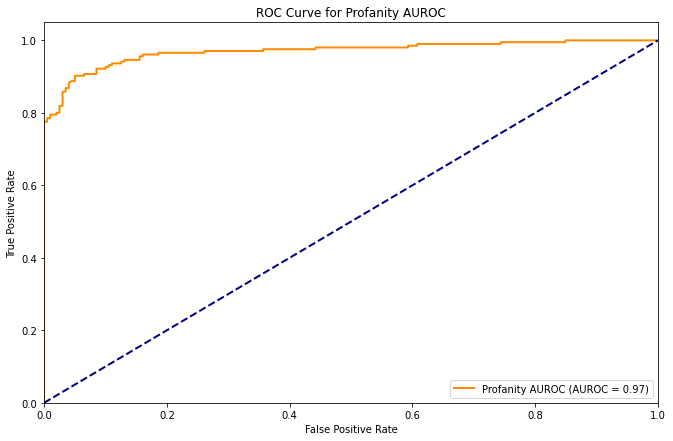


Eval results for Profanity.
accuracy : 91.09
precision : 90.43
recall : 92.2
f1 : 91.3
matthews_corrcoef : 82.19
roc_auc : 96.98
Checkpoint roberta_profanity_output/roberta_profanity/KoMultiText/0-91.3-ckpt saved.


epoch: 2, valid loss: 0.1317: 100%|████████████████████████████████████████| 101/101 [00:06<00:00, 16.29it/s]


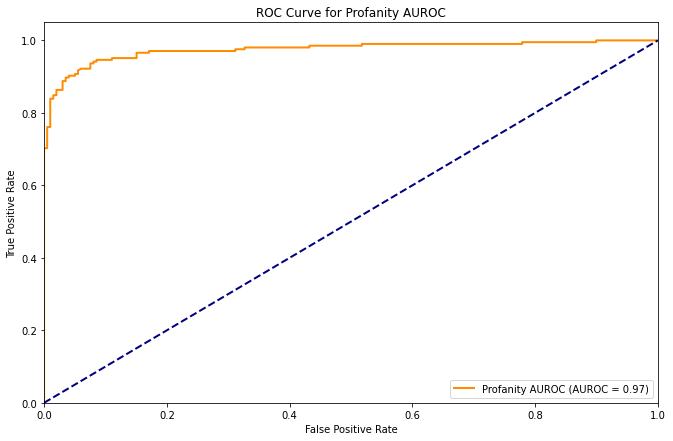


Eval results for Profanity.
accuracy : 92.82
precision : 92.31
recall : 93.66
f1 : 92.98
matthews_corrcoef : 85.65
roc_auc : 97.47
Checkpoint roberta_profanity_output/roberta_profanity/KoMultiText/1-92.98-ckpt saved.


epoch: 3, valid loss: 0.1257: 100%|████████████████████████████████████████| 101/101 [00:05<00:00, 17.48it/s]


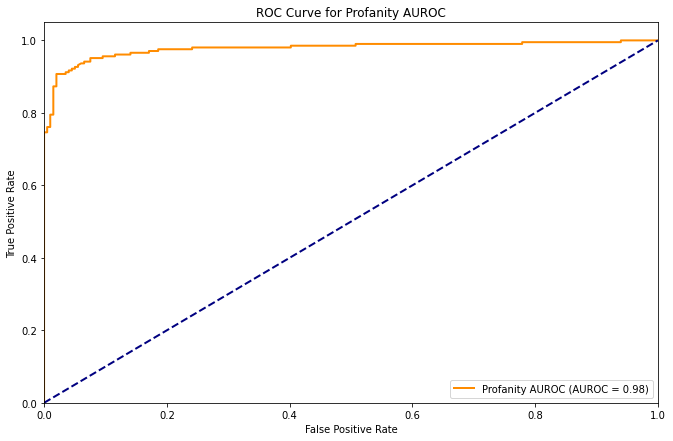


Eval results for Profanity.
accuracy : 93.56
precision : 93.24
recall : 94.15
f1 : 93.69
matthews_corrcoef : 87.13
roc_auc : 97.78
Checkpoint roberta_profanity_output/roberta_profanity/KoMultiText/2-93.69-ckpt saved.


epoch: 4, valid loss: 0.1368: 100%|████████████████████████████████████████| 101/101 [00:05<00:00, 17.41it/s]


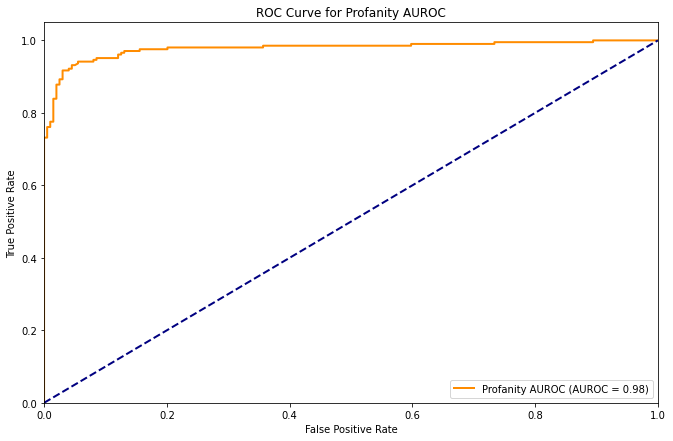


Eval results for Profanity.
accuracy : 94.06
precision : 94.15
recall : 94.15
f1 : 94.15
matthews_corrcoef : 88.12
roc_auc : 97.81
Checkpoint roberta_profanity_output/roberta_profanity/KoMultiText/3-94.15-ckpt saved.


epoch: 5, valid loss: 0.1437: 100%|████████████████████████████████████████| 101/101 [00:05<00:00, 17.36it/s]


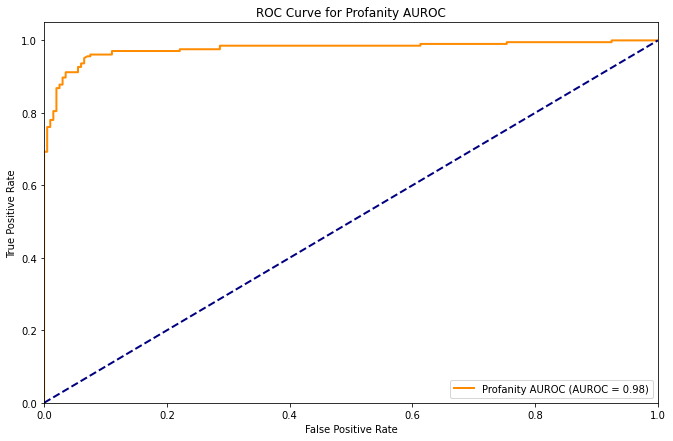


Eval results for Profanity.
accuracy : 93.32
precision : 91.2
recall : 96.1
f1 : 93.59
matthews_corrcoef : 86.75
roc_auc : 97.73


epoch: 6, train loss: 0.1523:  25%|█████████▌                             | 940/3836 [04:55<15:00,  3.22it/s]

In [ ]:
def do_eval(epoch):
    
    with torch.no_grad():
        # Run the model on the predict_dataloader and obtain results
        results = run_epoch(loader=predict_dataloader, epoch=epoch, is_train=False, **params)["result"]
        predictions = [item['prediction'] for item in results]
        labels = [item['label'] for item in results]
        probs = [item['prob'] for item in results]
        predictions = np.array([subitem for sublist in predictions for subitem in sublist])
        labels = np.array([subitem for sublist in labels for subitem in sublist])
        probs = np.array([subitem for sublist in probs for subitem in sublist])
        predictions = np.array(predictions)
        labels = np.array(labels)
        
        # Compute evaluation metrics using the eval_cls function
        eval_results = eval_cls(
            config=config,
            model=model,
            loader=predict_dataloader,
            tokenizer=model.tokenizer,
            predictions=predictions,  
            labels=labels,    
            probs=probs
        )
        
        print("\nEval results for Profanity.")
        for k, v in eval_results["results"].items():
            print(f"{k} : {v}")

    return eval_results["best_score"], eval_results["roc_auc"]

train_losses = []
val_f1 = []
val_roc_auc = []
if config.do_train:
    best_score = 0
    # Start training over a number of epochs
    for epoch in range(config.num_train_epochs):
        train_results = run_epoch(loader=train_dataloader, epoch=epoch, is_train=True, **params)
        train_loss = train_results['loss']
        train_losses.append(train_loss)
        
        # Evaluation during training (if configured to do so)
        if config.do_eval_during_train:
            f1_score, roc_auc = do_eval(epoch)
            val_f1.append(f1_score)
            val_roc_auc.append(roc_auc)
            
            # Checkpointing: Save the model if the F1 score is the best till now
            if f1_score >= best_score:
                best_score = f1_score
                output_dir = os.path.join(config.output_dir, config.task, config.dataset, f"{epoch}-{best_score}-ckpt")
                # Deep copy the model, move it to CPU, and save it
                copy.deepcopy(
                    model_dp.module
                    if hasattr(model_dp, "module")
                    else model_dp._models[0]
                    if hasattr(model_dp, "_models")
                    else model_dp
                ).cpu().save_pretrained(output_dir)
                # Save the current configuration to a JSON file in the checkpoint directory
                with open(os.path.join(output_dir, "finetune_config.json"), "w") as save_config:
                    json.dump(vars(config), save_config, sort_keys=True, indent=4)
                print(f"Checkpoint {output_dir} saved.")

In [ ]:
import matplotlib.pyplot as plt

# Setting up a canvas with 1 row and 2 columns to display the graphs side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# Plotting the Training Loss on the left side
axes[0].plot(train_losses, label="Train Loss", color='blue')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training Loss")
axes[0].legend()

# If evaluations during training is enabled, plot the F1 Score on the right side
if config.do_eval_during_train:
    axes[1].plot(val_f1, label="Profanity F1 Score", color='green')
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("F1 Score")
    axes[1].set_title("F1 Score")
    axes[1].legend()

# Display the plots
plt.tight_layout()
plt.show()
